# Deep Learning Time Series Approach 
---


## **1.Data Wrangling**
---

### **1.1 Import Library**

In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

### **1.2 Load Datasheet yang digunakan** 

In [36]:
df =pd.read_csv('../data/raw/Sunspots.csv')
print(df.head())

   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


In [37]:
print(df.tail())

      Unnamed: 0        Date  Monthly Mean Total Sunspot Number
3247        3247  2019-08-31                                0.5
3248        3248  2019-09-30                                1.1
3249        3249  2019-10-31                                0.4
3250        3250  2019-11-30                                0.5
3251        3251  2019-12-31                                1.6


In [38]:
df = df.drop(columns='Unnamed: 0',axis=1)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [39]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


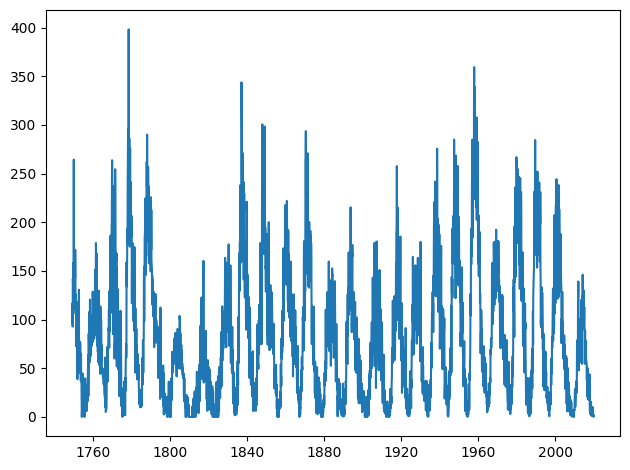

In [40]:
plt.plot(df['Monthly Mean Total Sunspot Number'])
plt.tight_layout()
plt.show()

In [41]:
def test_stationarity(timeseries):

    role_mean = timeseries.rolling(window=12).mean()
    role_std  = timeseries.rolling(window=12).std()

    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(role_mean, color='red', label='Rolling Mean')
    std  = plt.plot(role_std, color='black', label='Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

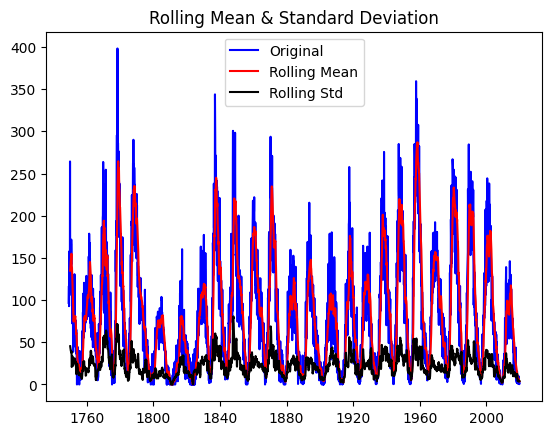

Results of Dickey-Fuller Test:
Test Statistic                -1.048087e+01
p-value                        1.214714e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.223000e+03
Critical Value (1%)           -3.432381e+00
Critical Value (5%)           -2.862437e+00
Critical Value (10%)          -2.567248e+00
dtype: float64


In [42]:
ts = df['Monthly Mean Total Sunspot Number']

test_stationarity(ts)

terlihat meansnya terus berubah sehingga tidak bisa disebut stasioner. menurut uji dickey-fuller, p-value = 0.99 > 0.05 sehingga HO gagal, data tidak stasioner, oleh karena itu kita perlu melakukan transformasi atau diffrencing 

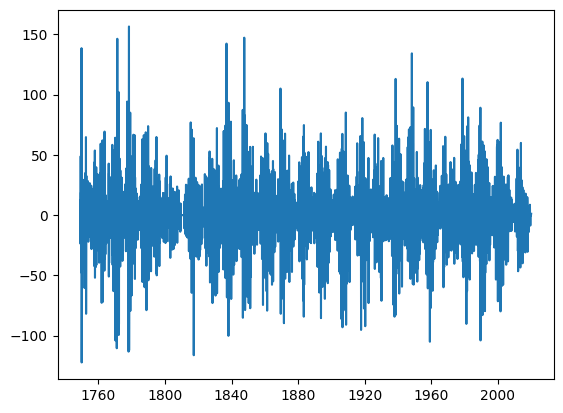

In [43]:
ts_diffrencing_1 = ts - ts.shift()
ts_diffrencing_1 = ts_diffrencing_1.dropna()
plt.plot(ts_diffrencing_1)

Terlihat masih belum stasioner, boleh coba diffrencing sekali lagi atau coba lanjutkan ke transformasi log

c:\Users\AlanFirdaus-ITMS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\AlanFirdaus-ITMS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


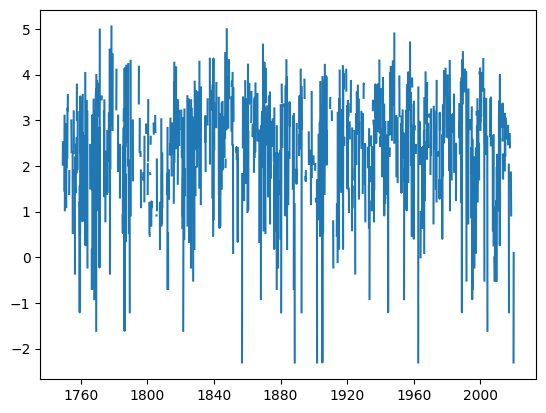

In [44]:
ts_diffrencing_log = np.log(ts_diffrencing_1)
plt.plot(ts_diffrencing_log)

Ternyata tidak lebih baik. Sekarang coba data awal yang ditransformasi log

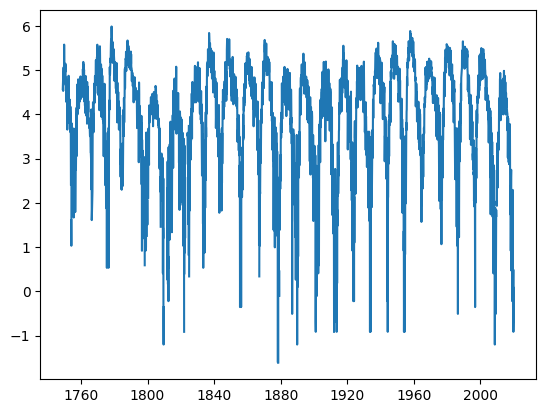

In [45]:
ts_log = np.log(ts)
plt.plot(ts_log)

Masih belum stasioner, tetapi secara varians terlihat lebih baik. Sekarang coba data yang ingin di diffrencing 

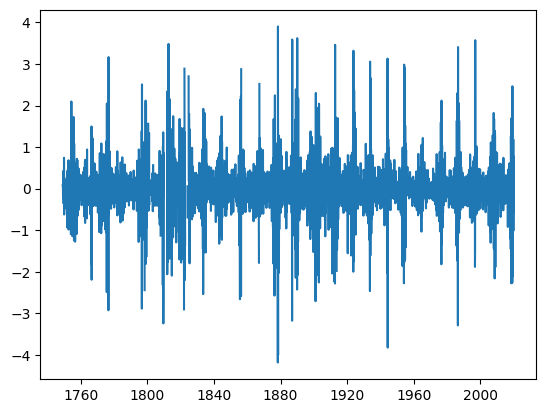

In [46]:
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

Sepertinya sudah stasioner, sekarang coba uji dickey-fuller supaya lebih meyakinkan

In [47]:
# test_stationarity(ts_log_1)